Use the following notebook, and fill in the relevant parts, to calculate the $a_\mu^{\text {HVP, LO}}$ integrand (sumand) in the the time-momentum representation.

# HVP and g-2 in the time-momentum representation with staggered (HISQ) fermions

In [1]:
import sys
import re
import os
import fnmatch
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
user=os.environ['USER']
%autosave 60

Autosaving every 60 seconds


## Utils

In [2]:
def jackblocks(data,jacks,omit):
    #loop over timeslices
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            if i not in omit:
                sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = sum-data[i,j]
                jacks[n,j] *= norm
                n=n+1
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err


def plot_integrand(name, jks, use_ainv=1):
    # outer loop over T, time to integrate up to in bounding method
    # get num jk blks and time size
    num_blks = jks.shape[0]
    time_size = int(jks.shape[1]/2+1)
    if use_ainv==1: # gev-1
        myainv = ainv
        plt.xlim(0,time_size/myainv)
        plt.xlabel('t (GeV$^{-1}$)')
    elif use_ainv==0: #lattice units
        myainv=1
        plt.xlabel('t/a')
        plt.xlim(0,time_size)
    else : #fm
        myainv=1/w0
        plt.xlim(0,time_size*w0)
        plt.xlabel('t (fm)')
    #plt.ylim(-10,100)
    #plt.title(name)
    plt.ylabel('$w$(t)$C$(t)')
    plt.tight_layout()

    corrL = np.zeros((num_blks,time_size))
    for t in range (1,time_size): 
        for n in range (num_blks):
            corrL[n][t] = 5*0.5*(jks[n][t]+jks[n][NT-t])*wt[t]

    for t in range(0,time_size-1):
        tt=corrL[...,t]
        y[t],yerr[t]=jack(tt)
        x[t]=t
    plt.errorbar(x/myainv,y/16*ainv,yerr/16*ainv,label=name,marker='o',markersize=2.5,linestyle='')
    plt.axhline(0)

    plt.savefig(name+"amu-integrand.pdf")

## Global Parameters

In [3]:
fm = 1/0.1973269804

## $64^3$

### Input params

compute the kernel w(t) on your own using Mathematica or python. Then proceed. If you run short on time, uncomment the relevant lines below to use mine. Be careful about charge factors (my conventions are unusual)

In [12]:
w0oa=1.95180
w0=0.1715/w0oa
dw0oa=0.00070
da=0.1715/w0oa*(0.0009**2/0.1715**2+dw0oa**2/w0oa**2)**0.5
print('lattice spacing, error (fm)=',w0,da)
w0m=w0 -da

NT=96
NS=64
mpi=0.1295
ainv = 1/w0/fm

# read QED kernel w(t) generated in mathematica
wt_file = open(r"64c/wt","r")
# for folded time extent, i.e. include t=96
wt=np.zeros(int(NT/2+1))
#for t in range (int(NT/2+1)):
#    wt[t] = float(wt_file.readline())

cstart={'h':500,'r':100,'s':100}
cend={'h':4300,'r':2600,'s':1600}
cinc=100
omit=[]
Nconf=0
for series in cstart:
    Nconf+=int((cend[series]-cstart[series])/cinc)
print("a(GeV)=",1/ainv, ', Nconf=', Nconf)

lattice spacing, error (fm)= 0.0878676093862076 0.00046218839138563174
a(GeV)= 0.4452893831755387 , Nconf= 78


### Data

read AMA data, average on a source time slice
do for approx and pretend this is the exact correlator (will do the AMA part later)

In [13]:
Ntsrc=8
Nssrc=4**3
tinc=12
Nmu=3
n=0
dset=np.zeros((Nconf,Ntsrc,NT))

for series in cstart:
    
    for traj in range(cstart[series],cend[series],cinc):

        if traj in omit:
            continue
        
        try:
            dirname=str('64c/data/meson_2pt/'+str(traj)+series+'/approx/')
            fl=os.listdir(dirname)
            for f in fl:
                if "cc" in f:
                    #print(f)
                    nsrc = int(int(f.split("_")[5])/tinc)
                    #print(nsrc)
                    fn=h5py.File(dirname+f,'r')
                    corr=fn['mesonCC/corr/']
                    dset[n][nsrc]+=corr['re']
                    fn.close()
            n+=1
        except:
            print("no file for ",traj+series)
            continue

dset /= Nmu * Nssrc

if n != Nconf:
    print('number of configs=', n,'doesn\'t agree with Nconf=', Nconf)

### Correlator

average over source time slices


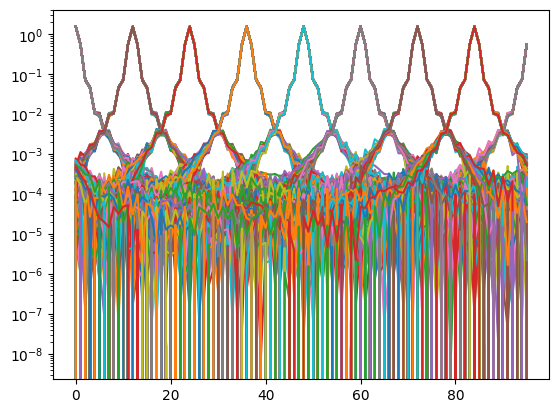

In [14]:
corrA=np.zeros((Nconf,NT))
plt.yscale("log")

for ts in range (Ntsrc):
    for nc in range (Nconf):
        plt.plot(dset[nc][ts])
        for t in range (NT):
            corrA[nc][(t-ts*tinc+NT)%NT] += dset[nc][ts][t]
corrA /= Ntsrc

make jackknife blocks

In [15]:
omit=[]
corrA_jk_blks=np.zeros((corrA.shape[0]-len(omit),NT))
jackblocks(corrA,corrA_jk_blks,omit)

omitting 0 of 78 configs


In [16]:
corrtot_jk_blks = corrA_jk_blks

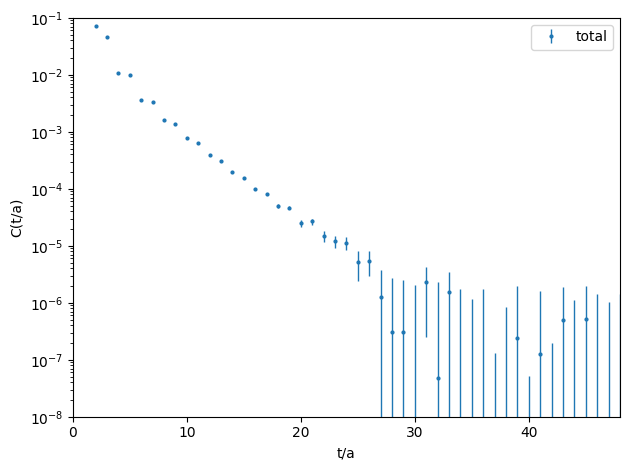

In [17]:
#plt.rc('axes', labelsize=20)
plt.ylim(1e-8,1e-1)
plt.xlim(0,NT/2)
plt.yscale("log")
plt.xlabel('t/a')
plt.ylabel('C(t/a)')
plt.tight_layout()

x=np.zeros(NT)
y=np.zeros(NT)
yerr=np.zeros(NT)
for t in range(0,NT):
    tt=corrtot_jk_blks[...,t]
    y[t],yerr[t]=jack(tt)
    x[t]=t
plt.errorbar(x,y,yerr,linestyle='',linewidth=1,marker='o',markersize=2,label='total')
plt.legend()

### full $a_\mu$ integrand

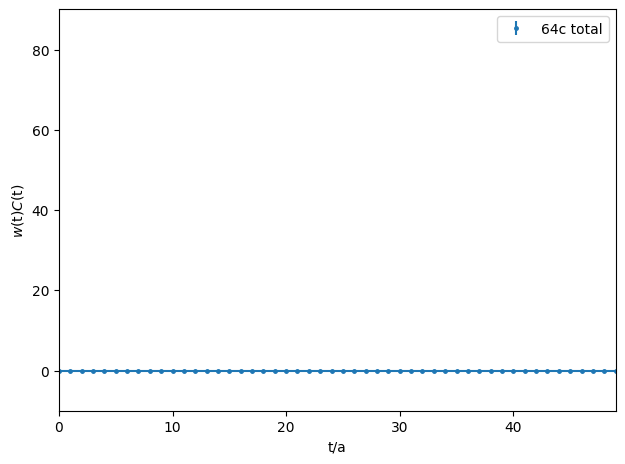

In [18]:
plot_integrand('64c total',corrtot_jk_blks,0)
plt.ylim(-10,90)
plt.legend()

### windows

1. Implement the window step function and repeat the above plot for the $0.4$ fm SD and 0.4-1 fm ID windows 

2. Compute the corresponding values for $a_\mu$. Does your value seem plausible?